# Hyperparameter exploration

In this notebook, we are going to model the circles dataset again, and see how not only the kernel, but all hyperparameters affect our outcome.

## Dataset

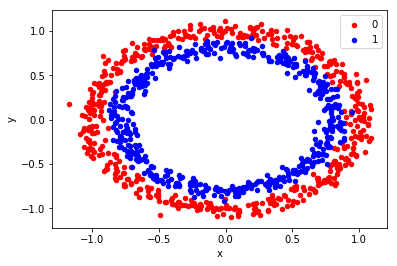

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=1000, noise=0.05)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}

fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

## MLP

First, we create our training and test sets again:

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Now, let's run the same model with linear kernel as before:

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

input_dim = X_train.shape[1]
output_dim = 1

model = Sequential()
model.add(Dense(50,input_dim=input_dim))
model.add(Activation('linear'))
model.add(Dense(50))
model.add(Activation('linear'))
model.add(Dense(output_dim))
model.add(Activation('sigmoid'))
model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

model.fit(X_train,y_train,epochs=10)

prediction_class = model.predict_classes(X_test)
prediction_prob = model.predict_proba(X_test)

print('Accuracy:', accuracy_score(y_test,prediction_class))
print('AUC:',roc_auc_score(y_test,prediction_prob))

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                150       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/

That's not very good is it? We knew this was coming from playing around in the TensorFlow playground and our earlier experiments. We can visualise the result as well:

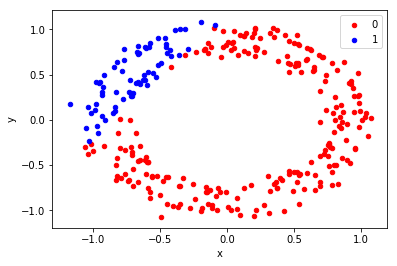

In [4]:
df = pd.DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=prediction_class[:,0]))
colors = {0:'red', 1:'blue'}

fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

The linear kernel is clearly not suitable. Let's try something different:

## Different hyperparameters

Let's explore a range of hyperparameters. More specifically, we will focus on:
- Activation function
- Number of neurons in a hidden layer
- Number of layers
- Learning rate
- Number of epochs

First we create the model:

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam

def nn_model(no_neurons,learning_rate,no_layers,kernel):
    model = Sequential()
    model.add(Dense(no_neurons,input_dim=input_dim))
    model.add(Activation(kernel))

    # Extra hidden layers
    for _ in range(0,no_layers):
        model.add(Dense(no_neurons))
        model.add(Activation(kernel))

    # Output
    model.add(Dense(output_dim))
    model.add(Activation('sigmoid'))
    model.compile(optimizer=Adam(lr=learning_rate),loss='binary_crossentropy',metrics=['accuracy'])
        
    return model

Next, we run the grid search:

In [6]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'no_neurons':[50,100],'kernel':['relu','sigmoid','linear'],'no_layers':[1,2],'learning_rate':[0.1,0.01,0.001],'epochs':[10,20],'verbose':[0]} 

grid_search = GridSearchCV(KerasClassifier(nn_model), parameters, cv=5,scoring='roc_auc')
grid_search.fit(X_train, y_train.ravel())

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']

print('Mean AUC (+/- standard deviation), for parameters')
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/- %0.03f) for %r"
          % (mean, std, params))

Mean AUC (+/- standard deviation), for parameters
0.994 (+/- 0.004) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 1, 'no_neurons': 50, 'verbose': 0}
0.987 (+/- 0.013) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 1, 'no_neurons': 100, 'verbose': 0}
0.974 (+/- 0.020) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 2, 'no_neurons': 50, 'verbose': 0}
0.978 (+/- 0.009) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 2, 'no_neurons': 100, 'verbose': 0}
0.996 (+/- 0.003) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.01, 'no_layers': 1, 'no_neurons': 50, 'verbose': 0}
0.991 (+/- 0.007) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.01, 'no_layers': 1, 'no_neurons': 100, 'verbose': 0}
0.995 (+/- 0.006) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.01, 'no_layers': 2, 'no_neurons': 50, 'verbose': 0}
0.992 (+/- 0.006) for {'epochs': 10, 'kernel': 'relu', 'learning_rate

Again, we see that the ReLU kernel clearly outperforms the linear and sigmoid one (although the sigmoid one is slightly higher and above 50%). Besides, we notice that the influence of epochs is apparent: results appear to be much more homogeneous over the various learning rates. The middle learning rate (0.01), however, tends to result in the highest AUC. The structure of the network (number of layers and number of neurons) seems to have little impact on the final results.
This shows how effective hyperparameter search can be in order to finetune your neural network.